In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

In [27]:
import scipy.signal

In [2]:
import nidaqmx

# Calibrate

In [120]:
with nidaqmx.Task() as aitask:
    aitask.ai_channels.add_ai_voltage_chan('Dev1/ai0')
    aitask.timing.cfg_samp_clk_timing(100.0)
      
    # read 10 samples
    data = aitask.read(10, timeout=1)

print("Voltage: {}+-{}".format(np.mean(data), np.std(data)))

Voltage: 2.2758176694737733+-0.000469510984173851


# Run tests

Generate a sample waveform. We have ao0 producing an output, which is sent to the Arduino, which modifies it in some way, and then the modified version is read on ai0

In [111]:
sampfreq = 500.0    # Hz
dur = 60.0    # sec
#amp = 1 # V
#freq = 2   # Hz

freq1 = 0.2
freq2 = 2

t = np.arange(0, dur, step=1.0/sampfreq)
# outwave = amp * np.sin(2*np.pi*freq * t) + 1.5
outwave = 0.4 * scipy.signal.chirp(t, f0=freq1, f1=freq2, t1=dur, method='logarithmic') + 1

freq = freq1 * (freq2/freq1)**(t/dur)

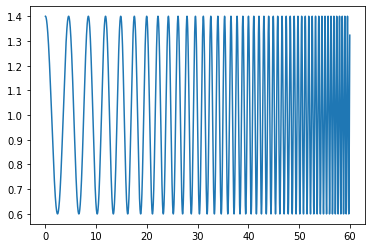

In [112]:
plt.plot(t, outwave)
plt.show()

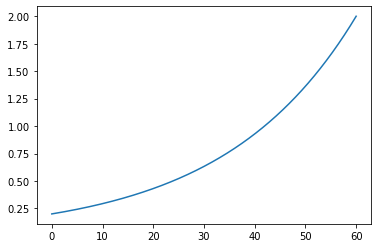

In [113]:
plt.plot(t, freq)

In [121]:
with nidaqmx.Task() as aitask, nidaqmx.Task() as aotask:
    aitask.ai_channels.add_ai_voltage_chan('Dev1/ai0')
    aitask.timing.cfg_samp_clk_timing(sampfreq, samps_per_chan=len(outwave))
    
    aotask.ao_channels.add_ao_voltage_chan('Dev1/ao0')
    
    aotask.timing.cfg_samp_clk_timing(sampfreq, source=u"/Dev1/ai/SampleClock",
                                     samps_per_chan=len(outwave))
    aotask.write(outwave, auto_start=True)
    
    aitask.start()
    data = aitask.read(len(outwave), timeout=dur+1)

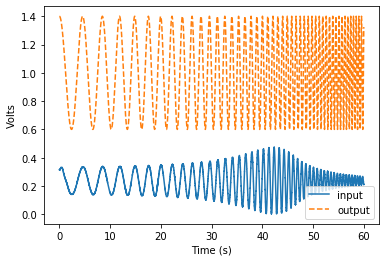

In [122]:
plt.plot(t, data, label='input')
plt.plot(t, outwave, '--', label='output')
plt.xlabel('Time (s)')
plt.ylabel('Volts')
plt.legend(loc='best')
# plt.xlim(0,1)
plt.show()

In [123]:
outH = scipy.signal.hilbert(outwave - np.mean(outwave))
inH = scipy.signal.hilbert(data - np.mean(data))

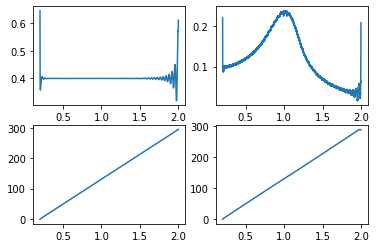

In [124]:
fig, ax = plt.subplots(2,2)
ax[0,0].plot(freq, np.abs(outH))
ax[1,0].plot(freq, np.unwrap(np.angle(outH)))

ax[0,1].plot(freq, np.abs(inH))
ax[1,1].plot(freq, np.unwrap(np.angle(inH)))

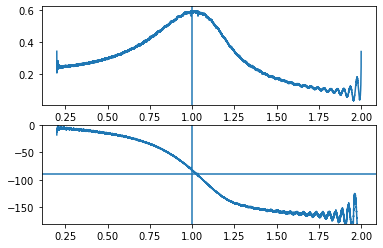

In [125]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(freq, np.abs(inH) / np.abs(outH))
ax[0].axvline(1.0)

ax[1].plot(freq, np.rad2deg(np.unwrap(np.angle(inH) - np.angle(outH))))

ax[1].set_ylim([-180, 0])
ax[1].axhline(-90)
ax[1].axvline(1.0)